# Carregar dados
* Busque dados do arquivo csv e coloque-os em um Pandas DataFrame.

In [12]:
import pandas as pd

covid_data = pd.read_csv('arquivos/time_series_covid_19_confirmed.csv')
covid_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,64575,65080,65486,65728,66275,66903,67743,68366,69130,70111
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,132118,132153,132176,132209,132215,132229,132244,132264,132285,132297
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,126156,126434,126651,126860,127107,127361,127646,127926,128198,128456
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,13569,13569,13569,13569,13569,13664,13671,13682,13693,13693
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,31661,31909,32149,32441,32623,32933,33338,33607,33944,34180


# Preparação de dados
* Como queremos prever casos para os BRasil, extrairemos a linha contendo os casos de covid confirmados nos Brasil.

In [13]:
us_covid_data = covid_data.loc[covid_data['Country/Region'] == 'Brazil']

us_covid_data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
30,NaN,Brazil,-14.235,-51.9253,0,0,0,0,0,0,...,15894094,15970949,16047439,16083258,16120756,16194209,16274695,16342162,16391930,16471600


### Dados de pré-processamento
* Podemos descartar as colunas para 'Província/Estado', 'País/Região', 'Lat' e 'Long', os dados são apenas para o Brasil e essas colunas não são necessárias para previsão.

In [14]:
us_covid_data = us_covid_data.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])

* Como o número de casos de Corona fica bastante grande ao longo do tempo, os cálculos do nosso modelo durante o treinamento podem ser muito lentos. Podemos corrigir isso usando o MinMaxScaler do sklearn para redimensionar nossos dados.

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(us_covid_data.values.T)
us_covid_data = scaler.transform(us_covid_data.values.T)

### Dividir em X e y
* Vamos configurar nosso X e y de tal forma que X[n] conterá os casos para uma certa quantidade de dias anteriores (time_steps) e y[n] conterá a leitura para o dia seguinte.
* Dessa forma, nosso modelo será treinado para prever o número de casos em um determinado dia com base na tendência do número de casos no número de dias de time_steps anterior.
* Após alguns testes, descobri que usar os dados dos 30 dias anteriores permitiu que nosso modelo fizesse previsões bastante precisas no 31º dia.

In [16]:
import numpy as np

X, y = [], []
time_steps = 30

for i in range(len(us_covid_data) - time_steps):
    x = us_covid_data[i:(i+time_steps), 0]
    X.append(x)
    y.append(us_covid_data[i+time_steps, 0])

X = np.array(X)
y = np.array(y)

# Particionamento de dados
* Devemos manter o conjunto de dados em ordem, pois estamos analisando uma linha do tempo cronológica dos casos de Corona, para que possamos usar os primeiros 80% dos dados como nosso treinamento e nossos testes serão os 20% restantes.
* Também precisamos remodelar as partições X para que nosso modelo possa processá-las corretamente.

In [17]:
split = int(len(X) * 0.8)

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Arquitetura do modelo
* Criamos nosso modelo usando uma arquitetura de rede neural recorrente.
* O modelo consiste em uma camada de entrada, seguida por três camadas LSTM que utilizam dropout para evitar que nosso modelo se ajuste demais.
* A saída é uma camada Densa com um único neurônio usando a função de ativação ReLU

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(48))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))


model.compile(loss = 'mean_squared_error',
              optimizer = RMSprop(),
              metrics = ['mean_squared_error'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 48)             15168     
                                                                 
 dropout_3 (Dropout)         (None, 1, 48)             0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 48)             18624     
                                                                 
 dropout_4 (Dropout)         (None, 1, 48)             0         
                                                                 
 lstm_5 (LSTM)               (None, 48)                18624     
                                                                 
 dropout_5 (Dropout)         (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

# Treinando  nosso modelo
* Agora podemos treinar nosso modelo usando 20% dos dados de treinamento como nosso conjunto de validação.
* O modelo usará o ReduceLROnPlateau para diminuir nossa taxa de aprendizado sempre que nossos platôs MSE de validação por três épocas para melhor precisão.

In [19]:
from keras.callbacks import ReduceLROnPlateau

batchsize = 100
epochs =  100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)

history = model.fit(X_train,
                    y_train,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

Epoch 1/100
3/3 [==============================] - 4s 462ms/step - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.2306 - val_mean_squared_error: 0.2306 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.2068 - val_mean_squared_error: 0.2068 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.1817 - val_mean_squared_error: 0.1817 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.1546 - val_mean_squared_error: 0.1546 - lr: 0.0010
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.1255 - val_mean_squared_error: 0.1255 - lr: 0.0010
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0955 - val_m

* Plote os valores de perda e MSE do modelo ao longo do treinamento.

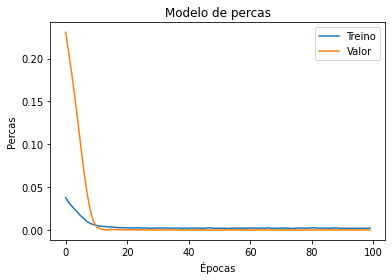

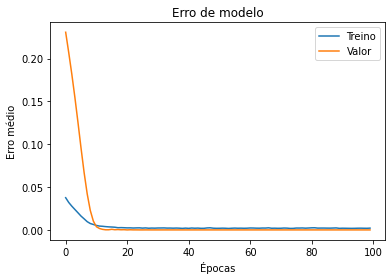

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo de percas')
plt.ylabel('Percas')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Valor'])
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Erro de modelo')
plt.ylabel('Erro médio')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Valor'])
plt.show()

# Previsões do modelo
* Para ver a precisão do nosso modelo, primeiro o usamos para prever a saída de nossos dados X_test.
* Em seguida, redimensionamos nossos dados de previsão e y_test de volta aos limites originais do conjunto de dados para plotar com precisão seus valores.
* Por fim, podemos traçar os casos reais de Covid em comparação com nossos casos previstos de Covid para ver a precisão geral do nosso modelo.

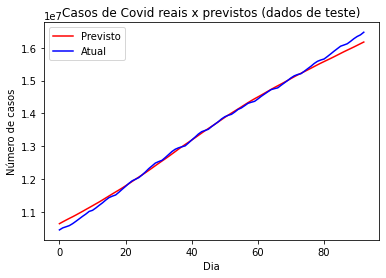

In [21]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(y_pred, color='red')
plt.plot(y_test, color='blue')
plt.title('Casos de Covid reais x previstos (dados de teste)')
plt.ylabel('Número de casos')
plt.xlabel('Dia')
plt.legend(['Previsto', 'Atual'])